In [4]:
import kagglegym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression

In [32]:
# The "environment" is our interface.
env = kagglegym.make()

# We get our initial observation by calling "reset".
o = env.reset()

excl = ["id", "timestamp", "y"]
col = [c for c in o.train.columns if c not in excl]
train = o.train.loc[:, col]

In [62]:
def preprocess(X):
    # Total number of NA values per observation.
    X.loc[:, "is_null"] = X.isnull().sum(axis=1)
    
    # Record NA values and then fill them with the median.
    d_mean = X.median(axis=0)

    for c in train.columns:
        X.loc[:, c + "_nan"] = pd.isnull(X[c])
        d_mean[c + "_nan"] = 0

    X.fillna(d_mean, inplace=True)

In [63]:
preprocess(train)

In [34]:
# Plot the correlation of the variables with the target value.
correlation = []
columns = []

for c in col:
    columns.append(c)
    correlation.append(np.corrcoef(train[c], o.train["y"])[0, 1])

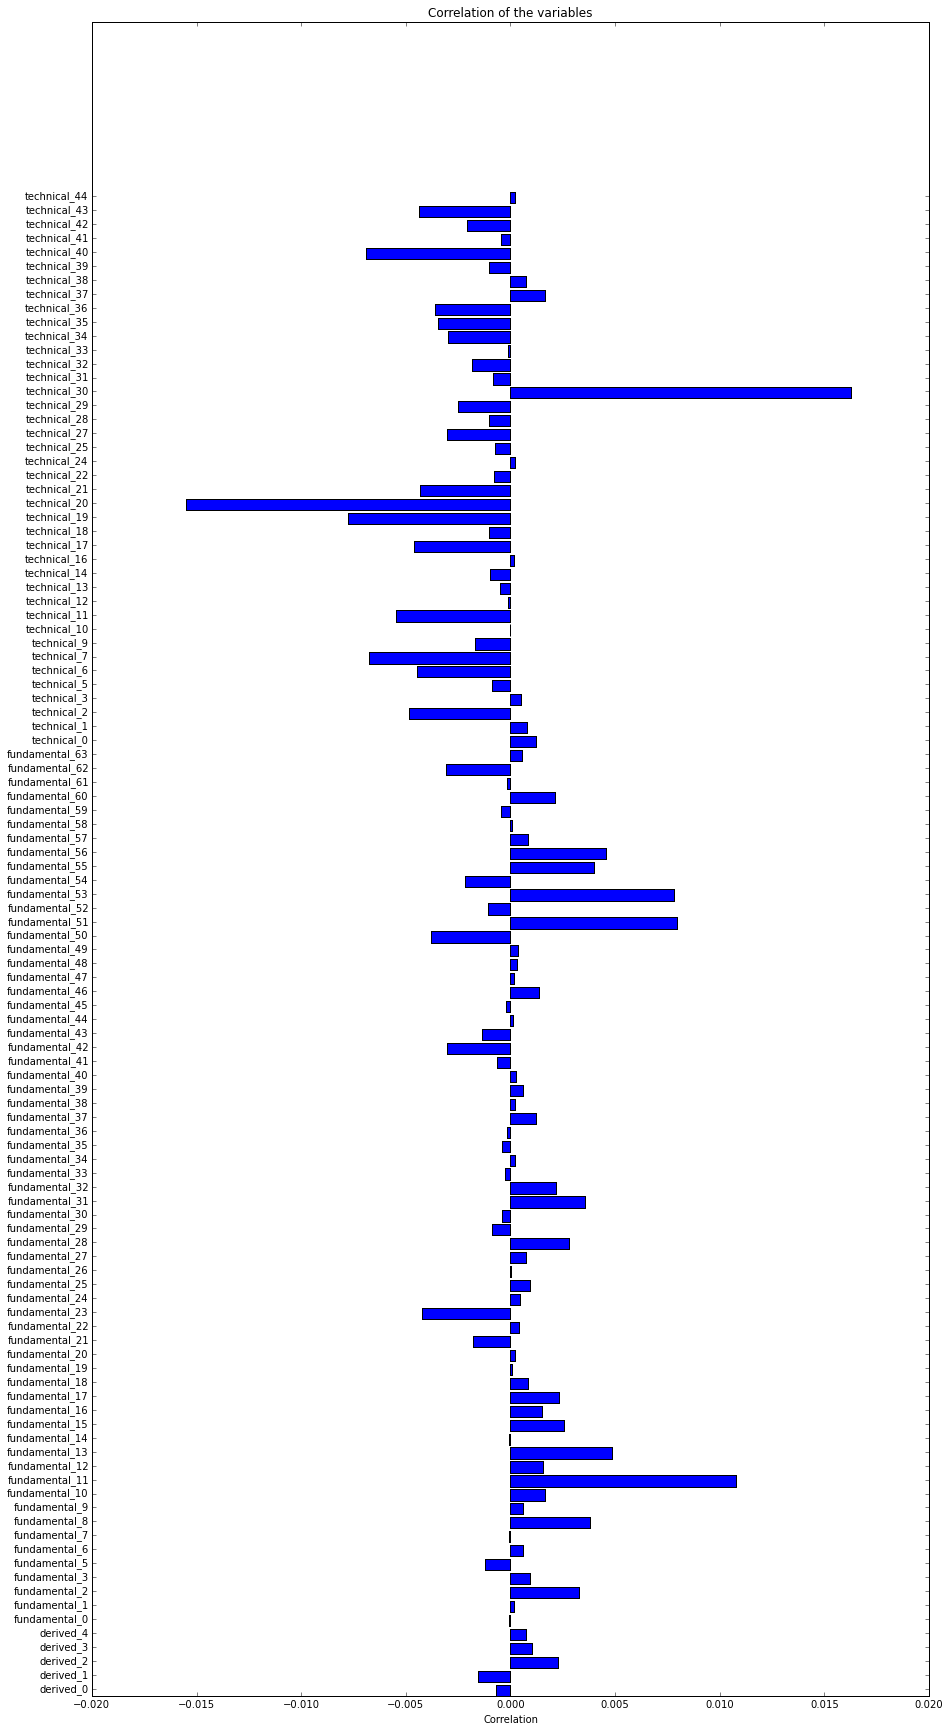

In [46]:
fig, ax = plt.subplots(figsize=(15, 30))
grid = np.arange(len(correlation))
ax.barh(grid, correlation)
ax.set_yticks(grid + 0.5)
ax.set_title("Correlation of the variables")
ax.set_xlabel("Correlation")
ax.set_yticklabels(columns, rotation="horizontal")
plt.show()

The most correlated variables are: technical_20, technical_30, fundamental_11.

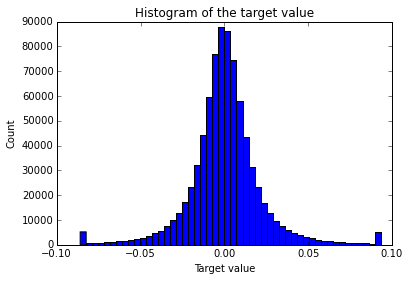

In [9]:
# Plot histogram of the target value.
plt.hist(o.train["y"], bins=50)
plt.title("Histogram of the target value")
plt.xlabel("Target value")
plt.ylabel("Count")
plt.show()

Notice the two spikes at the extremes of the histogram: the target might have been clipped and should be dealt with accordingly in our following linear model.

In [61]:
low_y_cut = -0.075
high_y_cut = 0.075
y_is_above_cut = (o.train.y > high_y_cut)
y_is_below_cut = (o.train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
model_1 = LinearRegression(n_jobs=-1)
model_1.fit(np.array(train.loc[y_is_within_cut, "technical_20"].values).reshape(-1,1), 
            o.train.loc[y_is_within_cut, "y"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [ ]:
# Fit an ExtraTreesRegressor
rfr = ExtraTreesRegressor(n_estimators=100, max_depth=4, n_jobs=-1, 
                          random_state=17, verbose=0)
model_2 = rfr.fit(train, o.train["y"])
train = []

In [ ]:
#https://www.kaggle.com/ymcdull/two-sigma-financial-modeling/ridge-lb-0-0100659
ymean_dict = dict(o.train.groupby(["id"])["y"].median())

while True:
    test = o.features.loc[:, col]
    preprocess(test)

    pred = o.target
    test_technical_20 = np.array(test["technical_20"].values).reshape(-1,1)
    
    # Ponderation of the two models.
    pred["y"] = ((model_1.predict(test_technical_20).clip(low_y_cut, high_y_cut) * 0.35)
                 + (model_2.predict(test).clip(low_y_cut, high_y_cut) * 0.65))
    # Add the median of the target value by ID.
    pred["y"] = pred.apply(lambda x: 0.95 * x["y"] + 0.05 * ymean_dict[x["id"]] if x["id"] in ymean_dict else x["y"], axis = 1)
    
    # The target values have 6 decimals in the training set.
    pred["y"] = [float(format(x, ".6f")) for x in pred["y"]]
    
    o, reward, done, info = env.step(pred)
    if done:
        print("Finished", info["public_score"])
        break
    if o.features.timestamp[0] % 100 == 0:
        print(reward)

In [ ]:
#0.0148877463784 for model_1 only